<img src="https://github.com/PKhosravi-CityTech/LightCnnRad/raw/main/Images/BioMindLogo.png" alt="BioMind AI Lab Logo" width="150" height="150" align="left" style="margin-bottom: 40px;"> **Repository Developed by Pegah Khosravi, Principal Investigator of the BioMind AI Lab**

Welcome to this repository! This repository is a result of collaborative efforts from our dedicated team at the lab. We are committed to advancing the field of biomedical AI and pushing the boundaries of medical data analysis. Your interest and contributions to our work are greatly appreciated. For more information about our lab and ongoing projects, please visit the [BioMind AI Lab website](https://sites.google.com/view/biomind-ai-lab). Thank you for your interest and support!


# Upload images

We are working with MR images provided at Global Robotics Institute.

Let's upload the images to Google Drive to ensure they are not lost every time we run the code in Colab.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Let's extract the contents of the compressed zip file.

In [ ]:
import zipfile
!unzip "/content/gdrive/MyDrive/ColabNotebooks_PegahKhosravi/Prostate_Project/DL_AutoRadAI/AutoRadAI_DL/Data_ProSliceFinder.zip" -d data

Please remove the "__MACOSX" file; it is unnecessary for our purposes.

In [3]:
!rm -rf '/content/data/__MACOSX'

Import all the necessary libraries.

In [4]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [5]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cuda


Transforms are applied to the input images to prepare them for the deep learning model. These transformations include resizing the images to 512x512 pixels, randomly flipping them horizontally for data augmentation, converting them to tensors, and normalizing the pixel values to have a mean of 0.5 and a standard deviation of 0.5, resulting in a standardized input format suitable for the neural network.

In [7]:
from torchvision import transforms

# Updated Transforms
transformer = transforms.Compose([
    transforms.Resize((512, 512)),  # Changed from (256,256) to (512, 512)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Converts image to tensor and scales pixels between 0 and 1
    transforms.Normalize([0.5, 0.5, 0.5],  # Normalizes pixel values to [-1, 1]
                         [0.5, 0.5, 0.5])
])


This section sets up data loaders for training, validation, and testing. It loads images from specific directories, applies transformations, and creates batches for efficient processing during model training and evaluation.

In [8]:
#Dataloader

#Path for Training, Validation, and Test directory
train_path="/content/data/Data_ProSliceFinder/Training"
validation_path="/content/data/Data_ProSliceFinder/Validation"
pred_path="/content/data/Data_ProSliceFinder/Test"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(validation_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [11]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

Remove the ".DS_Store" file from the training, validation, and test sets, as it is not needed. Please execute this section twice for each set, and before each run, ensure to execute the code above to ensure a clear path from the root.

In [12]:
!rm "/content/data/Data_ProSliceFinder/Training/.DS_Store"
!rm "/content/data/Data_ProSliceFinder/Validation/.DS_Store"
!rm "/content/data/Data_ProSliceFinder/Test/.DS_Store"

rm: cannot remove '/content/data/Data_ProSliceFinder/Training/.DS_Store': No such file or directory
rm: cannot remove '/content/data/Data_ProSliceFinder/Validation/.DS_Store': No such file or directory
rm: cannot remove '/content/data/Data_ProSliceFinder/Test/.DS_Store': No such file or directory


Here, we define the categories or classes within our dataset. It scans the training data directory, extracts the category names from the directory structure, and sorts them alphabetically for reference in our image classification task.

In [13]:
print(classes)

['Distinct', 'Non-Distinct']


In this section, we outline the architecture of the ProSliceFinder model.

In [14]:
import torch
import torch.nn as nn

class ProSliceFinder(nn.Module):
    def __init__(self, num_classes=2):
        super(ProSliceFinder, self).__init__()

        # Reduced number of blocks from 4 to 3 and decreased channels

        # Depthwise Separable Convolution Block 1
        self.conv1_dw = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, groups=3)
        self.conv1_pw = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Depthwise Separable Convolution Block 2
        self.conv2_dw = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, groups=12)
        self.conv2_pw = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(num_features=24)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Depthwise Separable Convolution Block 3
        self.conv3_dw = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1, groups=24)
        self.conv3_pw = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(num_features=36)
        self.relu3 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output from the last pooling layer
        final_dim = 512 // (2 ** 3)  # 512 / 8 = 64 (adjusting for fewer blocks)
        final_output_size = 36 * 64 * 64  # 36 channels * 64x64

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=final_output_size, out_features=128)
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, input):
        output = self.conv1_dw(input)
        output = self.conv1_pw(output)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2_dw(output)
        output = self.conv2_pw(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool(output)

        output = self.conv3_dw(output)
        output = self.conv3_pw(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool(output)

        output = output.view(-1, 36 * 64 * 64)  # Adjusted to the new size of the flattened layer

        output = self.fc1(output)
        output = self.relu5(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ProSliceFinder(num_classes=2).to(device)


In [15]:
from torchsummary import summary

model=model.cuda()

summary(model, (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 512, 512]              30
            Conv2d-2         [-1, 12, 512, 512]              48
       BatchNorm2d-3         [-1, 12, 512, 512]              24
              ReLU-4         [-1, 12, 512, 512]               0
         MaxPool2d-5         [-1, 12, 256, 256]               0
            Conv2d-6         [-1, 12, 256, 256]             120
            Conv2d-7         [-1, 24, 256, 256]             312
       BatchNorm2d-8         [-1, 24, 256, 256]              48
              ReLU-9         [-1, 24, 256, 256]               0
        MaxPool2d-10         [-1, 24, 128, 128]               0
           Conv2d-11         [-1, 24, 128, 128]             240
           Conv2d-12         [-1, 36, 128, 128]             900
      BatchNorm2d-13         [-1, 36, 128, 128]              72
             ReLU-14         [-1, 36, 1

Now, let's define the optimizer and Loss function.

In [16]:
#https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/
from torch.optim.adamw import AdamW
from torch.optim.adamax import Adamax
from torch.optim.sparse_adam import SparseAdam
from torch.optim.sgd import SGD
from torch.optim.adagrad import Adagrad
from torch.optim.rmsprop import RMSprop

In [17]:
optimizer = RMSprop(
    model.parameters(),
    lr=0.0001,      # Slightly higher starting learning rate
    alpha=0.9,       # Adjusted alpha
    eps=1e-08,
    weight_decay=0.0001,
    momentum=0.5,    # Added momentum
    centered=False
)


In [18]:
loss_function=nn.CrossEntropyLoss()

Next, let's set the desired number of epochs for training the model.

In [19]:
num_epochs=50

In [20]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))

Now, let's take a look at the number of images present in both the training and validation folders.

In [21]:
print(train_count,validation_count)

2736 457


Now, we proceed with training the model for the specified number of epochs using the images from the training and validation folders. During each epoch, we assess the model's performance, ultimately saving the best-performing model.

In [22]:
import torch
import numpy as np
import random

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Optional: Ensures that every run on the same machine yields the same result
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# Continue with the rest of your imports and code
import matplotlib.pyplot as plt
from torch.autograd import Variable



In [23]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch

# Initialize lists to store accuracy and loss values
train_accuracies = []
validation_accuracies = []
train_losses = []
validation_losses = []

# Model training and saving best model
best_accuracy = 0.0
patience = 5  # Set the patience for early stopping
patience_counter = 0  # Counter to track the number of epochs without improvement

for epoch in range(num_epochs):
    # Evaluation and training on the training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)  # Adjusted to use the actual batch size
        _, prediction = torch.max(outputs, 1)
        train_accuracy += torch.sum(prediction == labels).item()

    train_accuracy /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    # Evaluation mode for the validation process
    model.eval()
    validation_accuracy = 0.0
    validation_loss = 0.0

    for i, (images, labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        with torch.no_grad():
            outputs = model(images)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs, 1)
            validation_accuracy += torch.sum(prediction == labels).item()

    validation_accuracy /= len(validation_loader.dataset)
    validation_loss /= len(validation_loader.dataset)

    # Logging the metrics
    print(f'Epoch: {epoch} Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f} Train Accuracy: {train_accuracy:.4f} Validation Accuracy: {validation_accuracy:.4f}')

    # Append accuracy and loss values to the lists
    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    # Check if the current model is the best one
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = validation_accuracy
        patience_counter = 0  # Reset the patience counter if there's an improvement
    else:
        patience_counter += 1  # Increment the counter if no improvement

    # Early stopping check
    if patience_counter > patience:
        print("Early stopping triggered")
        break  # Break the loop if early stopping criteria met

# Plotting or further analysis could go here


Epoch: 0 Train Loss: 3.0643 Validation Loss: 0.5556 Train Accuracy: 0.6221 Validation Accuracy: 0.7681
Epoch: 1 Train Loss: 0.5683 Validation Loss: 0.3802 Train Accuracy: 0.7211 Validation Accuracy: 0.8359
Epoch: 2 Train Loss: 0.4731 Validation Loss: 0.5282 Train Accuracy: 0.7844 Validation Accuracy: 0.6893
Epoch: 3 Train Loss: 0.4413 Validation Loss: 0.3461 Train Accuracy: 0.7971 Validation Accuracy: 0.8687
Epoch: 4 Train Loss: 0.4239 Validation Loss: 0.3727 Train Accuracy: 0.8264 Validation Accuracy: 0.8315
Epoch: 5 Train Loss: 0.5677 Validation Loss: 0.2683 Train Accuracy: 0.7961 Validation Accuracy: 0.8621
Epoch: 6 Train Loss: 0.4072 Validation Loss: 0.2595 Train Accuracy: 0.8341 Validation Accuracy: 0.8906
Epoch: 7 Train Loss: 0.3232 Validation Loss: 0.2698 Train Accuracy: 0.8596 Validation Accuracy: 0.8862
Epoch: 8 Train Loss: 0.3111 Validation Loss: 0.2715 Train Accuracy: 0.8673 Validation Accuracy: 0.8796
Epoch: 9 Train Loss: 0.3221 Validation Loss: 0.2414 Train Accuracy: 0.867

In this code section, we create visualizations to track the training and validation accuracy, as well as the training and validation loss. The left subplot displays accuracy trends, while the right subplot shows loss trends. These visualizations offer insights into how the model performs and converges during training.

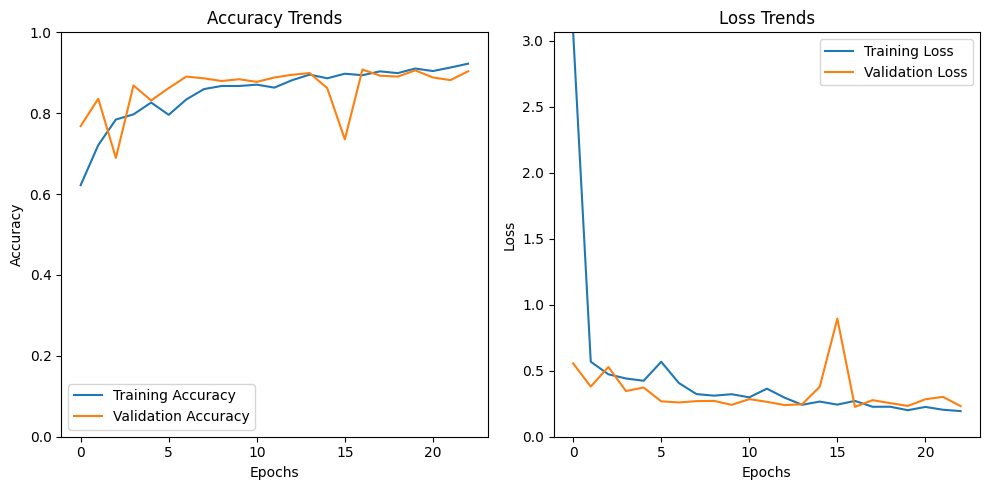

In [24]:
# Plotting the accuracy trends
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Trends')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1

# Plotting the loss trends
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trends')
plt.legend()
plt.ylim(0, max(max(train_losses), max(validation_losses)))  # Set y-axis limits from 0 to max value in data

# Display the plots
plt.tight_layout()
plt.show()

Now, let's test the best model on a blind test set. You can proceed with the following code for prediction.

In [25]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

In [26]:
train_path="/content/data/Data_ProSliceFinder/Training"
pred_path="/content/data/Data_ProSliceFinder/Test"

In [27]:
test_count=len(glob.glob(pred_path+'/*.png'))

In [28]:
print(test_count)

467


In [29]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [30]:
checkpoint=torch.load("best_checkpoint.model")
model=ProSliceFinder(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

ProSliceFinder(
  (conv1_dw): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  (conv1_pw): Conv2d(3, 12, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_dw): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
  (conv2_pw): Conv2d(12, 24, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3_dw): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24)
  (conv3_pw): Conv2d(24, 36, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=147456, out_features=128, bias=True)
  (relu5): ReLU()
  (dropout): Dropout(p=0.6, inplac

In [31]:
from torchvision import transforms

# Updated Transforms
transformer = transforms.Compose([
    transforms.Resize((512, 512)),  # Changed from (256,256) to (512, 512)
    transforms.ToTensor(),  # Converts image to tensor and scales pixels between 0 and 1
    transforms.Normalize([0.5, 0.5, 0.5],  # Normalizes pixel values to [-1, 1]
                         [0.5, 0.5, 0.5])
])


This code defines a prediction function to assess new MRI images using the trained ProSliceFinder model. It processes each image, generates predictions, and stores them in a dictionary. Finally, the probabilities are printed in the desired format for further analysis.

In [32]:
# Prediction function to predict class probabilities for an input image
def prediction(img_path, transformer, model):
    # Open and load the input image
    image = Image.open(img_path)

    # Apply transformations to the image
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # Perform inference (no need to compute gradients)
    with torch.no_grad():
        input = Variable(image_tensor)
        output = model(input)

    # Calculate class probabilities using softmax
    prob = nn.functional.softmax(output, dim=1)

    # Convert the tensor to a numpy array and move it to CPU
    prob = prob.cpu().detach().numpy()

    return prob

# Load the trained model and move it to the appropriate device (CPU or GPU)
model = ProSliceFinder(num_classes=2)  # Create an instance of the LightCnnRad
model.load_state_dict(checkpoint)  # Load the trained model's weights
if torch.cuda.is_available():
    model.cuda()  # Move the model to GPU if available

# Get a list of image paths to predict
images_path = glob.glob(pred_path + '/*.png')

# Dictionary to store predictions
pred_dict = {}

# Loop through each image and make predictions
for i in images_path:
    filename = i[i.rfind('/') + 1:]  # Extract the filename from the path
    prob_array = prediction(i, transformer, model)  # Get predicted probabilities
    pred_dict[filename] = prob_array  # Store the probabilities in the dictionary

# Print the probabilities in the desired format
for filename, prob_array in pred_dict.items():
    formatted_prob_array = np.array2string(
        prob_array, separator=', ', formatter={'float_kind': lambda x: f'{x:.8e}'}
    )
    print(f"'{filename}': np.array({formatted_prob_array}, dtype=np.float32),")

'Non_N_265_13.png': np.array([[2.56736457e-01, 7.43263602e-01]], dtype=np.float32),
'Non_Y_922_4.png': np.array([[7.35950947e-01, 2.64049083e-01]], dtype=np.float32),
'Non_N_255_25.png': np.array([[4.65097353e-02, 9.53490257e-01]], dtype=np.float32),
'Dis_N_624_10.png': np.array([[6.74356474e-03, 9.93256450e-01]], dtype=np.float32),
'Dis_Y_889_13.png': np.array([[8.05908501e-01, 1.94091514e-01]], dtype=np.float32),
'Dis_N_265_4.png': np.array([[9.87984836e-01, 1.20151835e-02]], dtype=np.float32),
'Non_N_259_3.png': np.array([[8.43440648e-05, 9.99915600e-01]], dtype=np.float32),
'Non_N_257_24.png': np.array([[3.31383490e-06, 9.99996662e-01]], dtype=np.float32),
'Non_Y_428_25.png': np.array([[3.03270936e-01, 6.96729064e-01]], dtype=np.float32),
'Non_N_255_18.png': np.array([[3.59831005e-02, 9.64016914e-01]], dtype=np.float32),
'Dis_Y_889_34.png': np.array([[9.99236226e-01, 7.63773976e-04]], dtype=np.float32),
'Dis_N_624_1.png': np.array([[5.31168759e-01, 4.68831241e-01]], dtype=np.float3

In [33]:
import csv
import numpy as np
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2

# Define the path for saving the CSV file
output_csv_path = '/content/predictions.csv'

# Save prediction results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predicted Class', 'Probability'])

    for filename, prob_array in pred_dict.items():
        predicted_class = 'Non-Distinct' if prob_array[0][1] > 0.5 else 'Distinct'  # Adjust the threshold as needed
        probability = prob_array[0][1]
        csvwriter.writerow([filename, predicted_class, probability])

print("Prediction results saved to", output_csv_path)

Prediction results saved to /content/predictions.csv


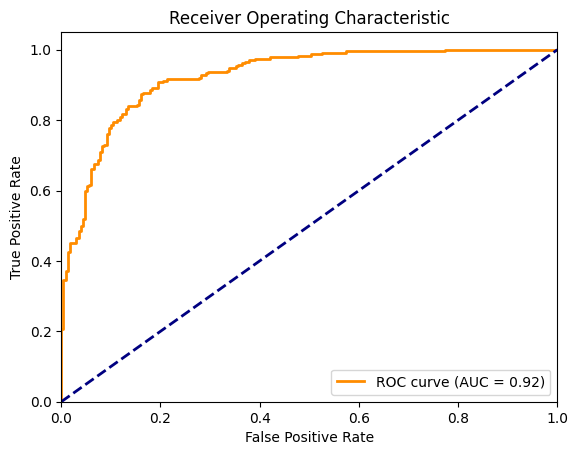

In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load data from predictions.csv
df = pd.read_csv('predictions.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Probability']

# Convert labels to binary format (0 for 'Dis_' and 1 for 'Non_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith('Dis_') else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc.pdf', bbox_inches='tight')
plt.show()

True Positive: 216
True Negative: 183
False Positive: 47
False Negative: 21
Accuracy: 0.854389721627409
Sensitivity (True Positive Rate): 0.9113924050632911
Specificity (True Negative Rate): 0.7956521739130434


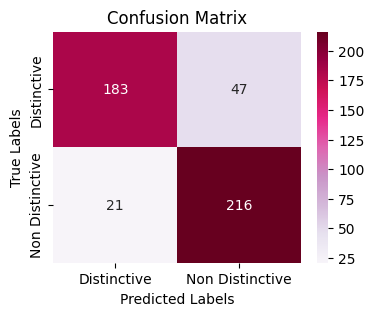

In [35]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file containing predictions
df = pd.read_csv('predictions.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to match the binary conversion used in ROC
# 0 for 'Dis_' (Distinctive) and 1 for 'Non_' (Non Distinctive)
true_labels_processed = [0 if label.startswith('Dis_') else 1 for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Probability'] >= threshold, 1, 0)  # 1 for Non Distinctive, 0 for Distinctive

# Calculate confusion matrix
class_labels = ['Distinctive', 'Non Distinctive']
cm = confusion_matrix(true_labels_processed, binary_predictions, labels=[0, 1])

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]  # Non Distinctive correctly predicted as Non Distinctive
tn = cm[0, 0]  # Distinctive correctly predicted as Distinctive
fp = cm[0, 1]  # Distinctive incorrectly predicted as Non Distinctive
fn = cm[1, 0]  # Non Distinctive incorrectly predicted as Distinctive

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='g', cmap='PuRd', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')
plt.show()
